In [3]:
import os
import comtypes.client
import zeep
import pandas as pd
# import matplotlib as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import io
from PIL import Image
import xlsxwriter
import io
from PIL import Image
import xlsxwriter
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def excel_to_pdf(infile=None, outfile=None):
    cwd = os.getcwd()
    infile = os.path.join(os.path.abspath(cwd), infile)
    outfile = os.path.join(os.path.abspath(cwd), outfile)
    # infile = "C:/Users/niejn/PycharmProjects/scrapy_demo/期货统计排名_交易所.xlsx"
    # outfile = "C:/Users/niejn/PycharmProjects/scrapy_demo/test5.pdf"
    app = comtypes.client.CreateObject('Excel.Application')
    app.Visible = False
    doc = app.Workbooks.Open(infile, ReadOnly=False)
    doc.ExportAsFixedFormat(0, outfile, 1, 0)
    doc.Close()
    app.Quit()
    comtypes.CoUninitialize()
    return

def getData(par_dict={"KSRQ": "2018-02-26", "JSRQ": "2018-02-26", "YYB": "1", "TJFL": "0"},
            lookout_str='cxSqlKHCJTJ_GPXZ'):
    wsdl = 'http://10.21.2.75:8080/service/LBEBusiness?wsdl'
    client = zeep.Client(wsdl=wsdl)
    # ns0:loginResult(message: xsd:string, result: xsd:int, sessionId: xsd:string)
    sessionId = client.service.login("ZXQH_GPXZ", "GPXZ123321", "myapp", "plain", "")
    # print(client.service.login("ZXQH_GPXZ", "GPXZ123321", "myapp", "plain", ""))
    factory = client.type_factory('ns0')
    string_type = client.get_type('xsd:string')
    lbParameter_type = client.get_type('ns0:lbParameter')
    queryOption_type = client.get_type('ns0:queryOption')
    '''		tmap.put("KSRQ", "2018-02-26");
    		tmap.put("JSRQ", "2018-02-26");
    		tmap.put("YYB", "1");
    		tmap.put("TJFL", "0");'''
    # par_dict = {"KSRQ": "2018-02-26", "JSRQ": "2018-02-26", "YYB": "1", "TJFL": "0"}
    params = []
    for key in par_dict:
        val = par_dict[key]
        temp_lbParameter = lbParameter_type(name=key, value=val)
        params.append(temp_lbParameter)

    valueOption_type = client.get_type('ns0:valueOption')
    valueOption = valueOption_type('VALUE')
    batchNo = 1
    batchSize = 3000
    ans_records = []
    mqueryOption = queryOption_type(batchNo=batchNo, batchSize=batchSize, queryCount=True, valueOption=valueOption)

    ans = client.service.query(sessionId.sessionId, lookout_str, params, "", mqueryOption)
    ans_records.extend(ans.records)

    while ((ans.result > 0) & ans.hasMore):
        batchNo += 1
        print('batchNo:{batchNo}'.format(batchNo=batchNo))

        mqueryOption = queryOption_type(batchNo=batchNo, batchSize=batchSize, queryCount=True, valueOption=valueOption)
        ans = client.service.query(sessionId.sessionId, lookout_str, params, "", mqueryOption)
        ans_records.extend(ans.records)
        # print(ans)
        print('batchNo:{batchNo}'.format(batchNo=batchNo))

    print(client.service.logout(sessionId.sessionId))
    return ans_records

def get_historydata():
    par_dict = {"KSRQ": "2018-01-01", "JSRQ": "2018-02-28", "ZB": "0", "ZQ": "0", "TJFL": "0"}
    lookout_str = 'SqlGPXZGSSCQS'

    records = getData(par_dict, lookout_str)
    # print(records)
    clean_records = []
    for a_record in records:
        clean_records.append(a_record.values)
    df = pd.DataFrame(clean_records, columns=['trade_type', 'time', 'sum', ])
    print(df.head())
    df['time'] = pd.to_datetime(df['time'])
    df['sum'] = df['sum'].astype(float)
    # df['sum'] = df['sum'] / df['sum'].max()

    df_market = df[df['trade_type'] == '市场']
    df_corpor = df[df['trade_type'] != '市场']

    join_df = df_market.set_index('time').join(df_corpor.set_index('time'), lsuffix='_market', rsuffix='_corpor')
    # print(join_df['sum_market'])

    return join_df


def get_historydata_exchange():
    par_dict = {"KSRQ": "2018-01-01", "JSRQ": "2018-02-28", "ZB": "0", "ZQ": "0", "TJFL": "0"}
    lookout_str = 'SqlGPXZGSSCQS'
    exchange_dict = {'1': '大连', '2': '上海', '3': '中金', '4': '郑州', }
    df_dict = {}
    for key in exchange_dict:
        par_dict['JYS'] = key
        records = getData(par_dict, lookout_str)
        # print(records)
        clean_records = []

        for a_record in records:
            clean_records.append(a_record.values)
        if not clean_records:
            return

        df = pd.DataFrame(clean_records, columns=['trade_type', 'time', 'sum', ])
        print(df.head())
        df['time'] = pd.to_datetime(df['time'])
        df['sum'] = df['sum'].astype(float)
        # df['sum'] = df['sum'] / df['sum'].max()

        df_market = df[df['trade_type'] == '市场']
        df_corpor = df[df['trade_type'] != '市场']

        join_df = df_market.set_index('time').join(df_corpor.set_index('time'), lsuffix='_market', rsuffix='_corpor')
        # print(join_df)
        # print(join_df['sum_market'])
        df_dict[exchange_dict[key]] = join_df
    df_dict['全市场'] = get_historydata()
        # print(join_df.head())
    return df_dict

def plot_to_excel(df_dict=None):
    
    img_list = []
    for key in df_dict:
        test_df = df_dict[key].copy()
        test_df = test_df.reset_index()
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
        plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
        fig, axes = plt.subplots(nrows=2, ncols=1, )
        fig.set_figheight(4)
        fig.set_figwidth(6)
        test_df['time'] = test_df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
        ax = test_df[['time', 'sum_corpor']].plot(
            x='time', linestyle='-', marker='o', ax=axes[0])
        ax2 = test_df[['time', 'sum_market']].plot(
            x='time', linestyle='-', marker='o', secondary_y=True, ax=axes[0])
        test_df[['time', 'sum_corpor', 'sum_market']].plot(x='time', kind='bar'

                                                           , logy=True
                                                           , sharex=True
                                                           , ax=axes[1])

        def currency(x, pos):
            'The two args are the value and tick position'
            if x >= 1000000:
                return '${:1.1f}M'.format(x * 1e-6)
            return '${:1.0f}K'.format(x * 1e-3)

        def percent(x, pos):
            return '%.2f%%' % (x * 100)

        formatter = FuncFormatter(percent)
        axes[0].yaxis.set_major_formatter(formatter)
        axes[0].legend(['中信期货市场占比', '市场成交量'])

        ax2.yaxis.set_major_formatter(formatter)
        axes[1].yaxis.set_major_formatter(formatter)
        fig.suptitle('{exchange}期货交易所成交市场占比'.format(exchange=key), fontsize=14, fontweight='bold');
        imgdata = BytesIO()
        fig.savefig(imgdata, format="png")
        imgdata.seek(0)
        img_list.append(imgdata)
    workbook = xlsxwriter.Workbook('期货持仓分析报告.xlsx')
    worksheet = workbook.add_worksheet("全市场成交统计")
    num = 5
    for img in img_list:
        # imgdata.seek(0)
        # use with xlsxwriter
        image_path = 'sales.png'
        bound_width_height = (240, 240)
        worksheet.insert_image('A{num}'.format(num=num), image_path, {'image_data': img, })
        # image_path = '{exchange}期货交易所成交市场占比.png'.format(exchange=key)
        # worksheet.insert_image('A{pos}'.format(pos=str(img_pos)), image_path, {'image_data': imgdata, })
        num += 30

    workbook.close()

    filename = "期货持仓分析报告"
    # excel_to_pdf('{filename}.xlsx'.format(filename=filename), '{filename}.pdf'.format(filename=filename))
    return
df_dict = get_historydata_exchange()

{
    'message': '成功',
    'result': 1
}
  trade_type      time    sum
0         公司  20180102  18175
1         市场  20180102  89762
2         公司  20180103  15883
3         市场  20180103  80229
4         公司  20180104  14544


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   130115
1         市场  20180102  3387024
2         市场  20180103  3381688
3         公司  20180103   103629
4         公司  20180104   144542


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   291152
1         市场  20180102  6501486
2         市场  20180103  7112008
3         公司  20180103   292624
4         公司  20180104   326502


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   285783
1         市场  20180102  7006530
2         公司  20180103   247007
3         市场  20180103  6493134
4         公司  20180104   275341


{
    'message': '成功',
    'result': 1
}
  trade_type      time       sum
0         公司  20180102    725225
1         市场  20180102  16984802
2         市场  20180103  17067059
3         公司  20180103    659143
4         公司  20180104    760929


In [8]:
# df_dict = get_historydata_exchange()
# img_list = []
# for key in df_dict:
#     cp_df = df_dict[key].copy()
#     cp_df = cp_df.reset_index()
#     test_df = cp_df['time', 'sum_market','sum_corpor',]
#     name_map = {'time' : '时间', 'sum_market' : '市场成交量','sum_corpor' : '中信成交量',}
#     test_df = test_df.rename(name_map, axis='columns')
#     print(test_df)
#     # time
#     # df.rename(str.lower, axis='columns')
#     #  trade_type_market  sum_market trade_type_corpor  sum_corpor
#     test_df['corpor_div_market'] = test_df['sum_corpor'] / test_df['sum_market']
#     # test_df = test_df.reset_index()
#     plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
#     plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
#     fig, axes = plt.subplots(nrows=2, ncols=1, )
#     fig.set_figheight(4)
#     fig.set_figwidth(6)
#     test_df['time'] = test_df['time'].apply(lambda x: x.strftime('%m-%d'))
#     ax = test_df[['time', 'corpor_div_market']].plot(
#         x='time', linestyle='-', marker='o', ax=axes[0])
#     ax2 = test_df[['time', 'sum_market']].plot(
#         x='time', linestyle='-', marker='o', secondary_y=True, ax=axes[0])
#     test_df[['time', 'sum_corpor', 'sum_market']].plot(x='time', kind='bar'
# 
#                                                        , logy=True
#                                                        , sharex=True
#                                                        , ax=axes[1])
# 
#     def currency(x, pos):
#         'The two args are the value and tick position'
#         if x >= 1000000:
#             return '${:1.1f}M'.format(x * 1e-6)
#         return '${:1.0f}K'.format(x * 1e-3)
# 
#     def percent(x, pos):
#         return '%.2f%%' % (x * 100)
# 
#     formatter = FuncFormatter(percent)
#     axes[0].yaxis.set_major_formatter(formatter)
#     # ax.legend(['中信占比',])
#     # ax2.legend(['市场成交量'])
#     ax2.yaxis.set_major_formatter(formatter)
#     # axes[1].yaxis.set_major_formatter(formatter)
#     fig.suptitle('{exchange}期货交易所成交市场占比'.format(exchange=key), fontsize=14, fontweight='bold');
#     imgdata = BytesIO()
#     fig.savefig(imgdata, format="png")
#     imgdata.seek(0)
#     img_list.append(imgdata)


{
    'message': '成功',
    'result': 1
}
  trade_type      time    sum
0         公司  20180102  18175
1         市场  20180102  89762
2         公司  20180103  15883
3         市场  20180103  80229
4         公司  20180104  14544


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   130115
1         市场  20180102  3387024
2         市场  20180103  3381688
3         公司  20180103   103629
4         公司  20180104   144542


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   285783
1         市场  20180102  7006530
2         公司  20180103   247007
3         市场  20180103  6493134
4         公司  20180104   275341


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   291152
1         市场  20180102  6501486
2         市场  20180103  7112008
3         公司  20180103   292624
4         公司  20180104   326502


{
    'message': '成功',
    'result': 1
}
  trade_type      time       sum
0         公司  20180102    725225
1         市场  20180102  16984802
2         市场  20180103  17067059
3         公司  20180103    659143
4         公司  20180104    760929
dict_keys(['郑州', '大连', '中金', '全市场', '上海'])


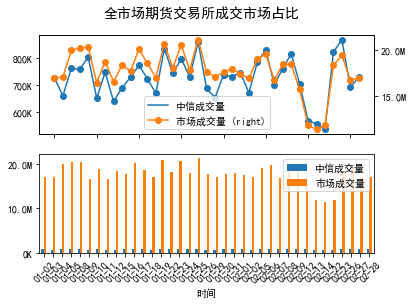

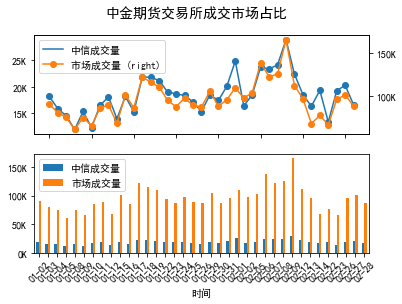

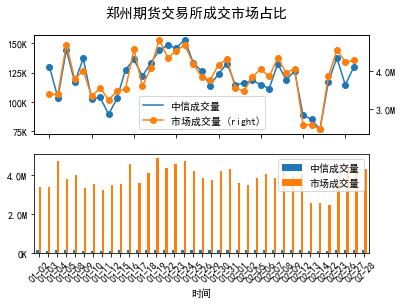

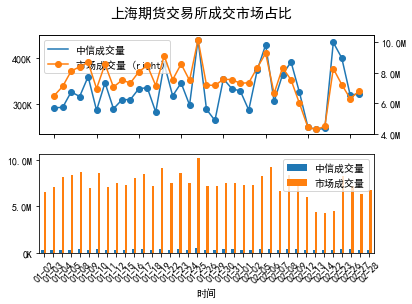

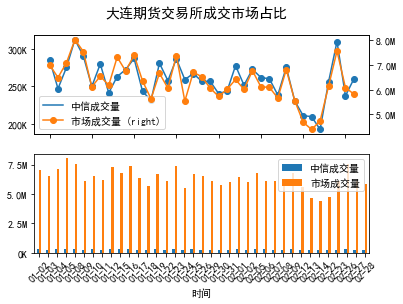

In [3]:
df_dict = get_historydata_exchange()
img_list = []
# dict_keys(['中金', '郑州', '全市场', '上海', '大连'])
df_keys = ['全市场','中金', '郑州', '上海', '大连']
print(df_dict.keys())
# import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
filename = "期货持仓分析报告1"
pdf = PdfPages('{filename}.pdf'.format(filename=filename))
for key in df_keys:
    cp_df = df_dict[key].copy()
    cp_df = cp_df.reset_index()
    test_df = cp_df[['time', 'sum_market', 'sum_corpor', ]]
    name_map = {'time': '时间', 'sum_market': '市场成交量', 'sum_corpor': '中信成交量', }
    test_df = test_df.rename(name_map, axis='columns')
    # print(test_df)
    # time
    # df.rename(str.lower, axis='columns')
    #  trade_type_market  sum_market trade_type_corpor  sum_corpor
    test_df['中信占比'] = test_df['中信成交量'] / test_df['市场成交量']
    # test_df = test_df.reset_index()
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    fig, axes = plt.subplots(nrows=2, ncols=1, )
    fig.set_figheight(4)
    fig.set_figwidth(6)
    test_df['时间'] = test_df['时间'].apply(lambda x: x.strftime('%m-%d'))
    ax = test_df[['时间', '中信成交量']].plot(
        x='时间', linestyle='-', marker='o', ax=axes[0])
    ax2 = test_df[['时间', '市场成交量']].plot(
        x='时间', linestyle='-', marker='o', secondary_y=True, ax=axes[0])
    ax3 = test_df[['时间', '中信成交量', '市场成交量']].plot(x='时间', kind='bar'
                                                 # , logy=True
                                                 , sharex=True
                                                 , ax=axes[1])

    def currency(x, pos):
        'The two args are the value and tick position'
        if x >= 1000000:
            return '${:1.1f}M'.format(x * 1e-6)
        return '${:1.0f}K'.format(x * 1e-3)

    def position(x, pos):
        'The two args are the value and tick position'
        if x >= 1000000:
            return '{:1.1f}M'.format(x * 1e-6)
        return '{:1.0f}K'.format(x * 1e-3)

    def percent(x, pos):
        return '%.2f%%' % (x * 100)

    formatter = FuncFormatter(percent)
    pos_formatter = FuncFormatter(position)
    axes[0].yaxis.set_major_formatter(pos_formatter)
    axes[1].yaxis.set_major_formatter(pos_formatter)
    # ax.legend(['中信占比',])
    # ax2.legend(['市场成交量'])
    # ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    # ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    # ax2.legend(loc='center left', )
    # ax.legend(loc='center left', )
    ax2.yaxis.set_major_formatter(pos_formatter)
    # axes[1].yaxis.set_major_formatter(pos_formatter)
    # handles = [ax, ax2, ]
    # labels = ['dataset1', 'dataset2', ]
    # axes[0].legend( loc=4, ncol=1, numpoints=1, frameon=False)

    axes[1].xaxis.set_tick_params(rotation=45)
    fig.suptitle('{exchange}期货交易所成交市场占比'.format(exchange=key), fontsize=14, fontweight='bold');
    # fig.legend((ax, ), ('Line 1', ), "right")
    imgdata = BytesIO()
    fig.savefig(imgdata, format="png")
    imgdata.seek(0)
    img_list.append(imgdata)
    pdf.savefig(fig)
    
pdf.close()
workbook = xlsxwriter.Workbook('期货持仓分析报告.xlsx')
worksheet = workbook.add_worksheet("全市场成交统计")
num = 1
for img in img_list:
    # imgdata.seek(0)
    # use with xlsxwriter
    image_path = 'sales.png'
    bound_width_height = (240, 240)
    worksheet.insert_image('A{num}'.format(num=num), image_path, {'image_data': img, })
    # image_path = '{exchange}期货交易所成交市场占比.png'.format(exchange=key)
    # worksheet.insert_image('A{pos}'.format(pos=str(img_pos)), image_path, {'image_data': imgdata, })
    num += 20

workbook.close()

filename = "期货持仓分析报告"
# excel_to_pdf('{filename}.xlsx'.format(filename=filename), '{filename}.pdf'.format(filename=filename))



In [4]:
workbook = xlsxwriter.Workbook('期货持仓分析报告.xlsx')
worksheet = workbook.add_worksheet("全市场成交统计")
num = 1
for img in img_list:
    # imgdata.seek(0)
    # use with xlsxwriter
    image_path = 'sales.png'
    bound_width_height = (240, 240)
    worksheet.insert_image('A{num}'.format(num=num), image_path, {'image_data': img, })
    # image_path = '{exchange}期货交易所成交市场占比.png'.format(exchange=key)
    # worksheet.insert_image('A{pos}'.format(pos=str(img_pos)), image_path, {'image_data': imgdata, })
    num += 30

workbook.close()

filename = "期货持仓分析报告"
excel_to_pdf('{filename}.xlsx'.format(filename=filename), '{filename}.pdf'.format(filename=filename))


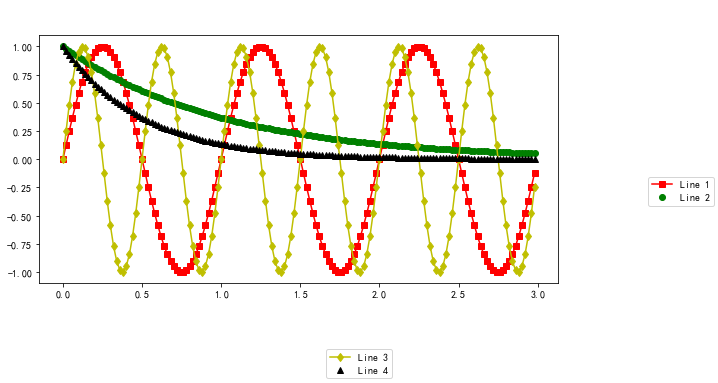

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()
fig.set_size_inches((10,10))

gs1 = gridspec.GridSpec(1, 1)
ax1 = fig.add_subplot(gs1[0])

x = np.arange(0.0, 3.0, 0.02)
y1 = np.sin(2*np.pi*x)
y2 = np.exp(-x)
l1, l2 = ax1.plot(x, y1, 'rs-', x, y2, 'go')

y3 = np.sin(4*np.pi*x)
y4 = np.exp(-2*x)
l3, l4 = ax1.plot(x, y3, 'yd-', x, y4, 'k^')

fig.legend((l1, l2), ('Line 1', 'Line 2'), "right")
fig.legend((l3, l4), ('Line 3', 'Line 4'), "lower center")

gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])

In [6]:
df_dict = get_historydata_exchange()

# dict_keys(['中金', '郑州', '全市场', '上海', '大连'])


{
    'message': '成功',
    'result': 1
}
  trade_type      time    sum
0         公司  20180102  18175
1         市场  20180102  89762
2         公司  20180103  15883
3         市场  20180103  80229
4         公司  20180104  14544


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   130115
1         市场  20180102  3387024
2         公司  20180103   103629
3         市场  20180103  3381688
4         公司  20180104   144542


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   285783
1         市场  20180102  7006530
2         公司  20180103   247007
3         市场  20180103  6493134
4         公司  20180104   275341


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   291152
1         市场  20180102  6501486
2         公司  20180103   292624
3         市场  20180103  7112008
4         市场  20180104  8113074


{
    'message': '成功',
    'result': 1
}
  trade_type      time       sum
0         公司  20180102    725225
1         市场  20180102  16984802
2         市场  20180103  17067059
3         公司  20180103    659143
4         公司  20180104    760929


dict_keys(['郑州', '大连', '中金', '全市场', '上海'])
           时间       市场成交量     中信成交量
0  2018-01-02  16984802.0  725225.0
1  2018-01-03  17067059.0  659143.0
2  2018-01-04  19994012.0  760929.0
3  2018-01-05  20261996.0  757809.0
4  2018-01-08  20317680.0  803234.0
5  2018-01-09  16462409.0  650164.0
6  2018-01-10  18755486.0  747125.0
7  2018-01-11  16559392.0  638174.0
8  2018-01-12  18366291.0  689174.0
9  2018-01-15  17714772.0  727874.0
10 2018-01-16  20130581.0  772415.0
11 2018-01-17  18558376.0  722764.0
12 2018-01-18  17002119.0  668215.0
13 2018-01-19  20733209.0  834565.0
14 2018-01-22  18058118.0  742742.0
15 2018-01-23  20582916.0  797618.0
16 2018-01-24  17845555.0  728180.0
17 2018-01-25  21173718.0  859439.0
18 2018-01-26  17660680.0  686563.0
19 2018-01-29  17095500.0  652751.0
20 2018-01-30  17563864.0  737057.0
21 2018-01-31  17987282.0  729794.0
22 2018-02-01  17394991.0  745789.0
23 2018-02-02  16917923.0  670601.0
24 2018-02-05  19049534.0  783705.0
25 2018-02-06  195899

           时间      市场成交量     中信成交量
0  2018-01-02  3387024.0  130115.0
1  2018-01-03  3381688.0  103629.0
2  2018-01-04  4718176.0  144542.0
3  2018-01-05  3790508.0  116830.0
4  2018-01-08  4018464.0  137122.0
5  2018-01-09  3327718.0  102365.0
6  2018-01-10  3557058.0  103860.0
7  2018-01-11  3233558.0   89479.0
8  2018-01-12  3470910.0  103047.0
9  2018-01-15  3529662.0  127597.0
10 2018-01-16  4587286.0  136237.0
11 2018-01-17  3601718.0  122031.0
12 2018-01-18  4099180.0  133329.0
13 2018-01-19  4849336.0  144310.0
14 2018-01-22  4359788.0  148351.0
15 2018-01-23  4546308.0  145896.0
16 2018-01-24  4711464.0  153192.0
17 2018-01-25  4209688.0  133652.0
18 2018-01-26  3849690.0  126213.0
19 2018-01-29  3763952.0  113979.0
20 2018-01-30  4176916.0  124134.0
21 2018-01-31  4328780.0  132634.0
22 2018-02-01  3561836.0  114698.0
23 2018-02-02  3465230.0  116152.0
24 2018-02-05  3853728.0  118305.0
25 2018-02-06  4059388.0  114869.0
26 2018-02-07  3862716.0  111446.0
27 2018-02-08  43560

           时间       市场成交量     中信成交量
0  2018-01-02   6501486.0  291152.0
1  2018-01-03   7112008.0  292624.0
2  2018-01-04   8113074.0  326502.0
3  2018-01-05   8386462.0  316237.0
4  2018-01-08   8683398.0  360057.0
5  2018-01-09   6958586.0  285685.0
6  2018-01-10   8561396.0  346690.0
7  2018-01-11   7056628.0  289260.0
8  2018-01-12   7510152.0  309023.0
9  2018-01-15   7326760.0  309554.0
10 2018-01-16   8061270.0  333510.0
11 2018-01-17   8478880.0  335555.0
12 2018-01-18   7154966.0  282040.0
13 2018-01-19   9108930.0  388012.0
14 2018-01-22   7542218.0  317756.0
15 2018-01-23   8571250.0  346062.0
16 2018-01-24   7498644.0  297543.0
17 2018-01-25  10171338.0  441469.0
18 2018-01-26   7195974.0  288084.0
19 2018-01-29   7161398.0  263510.0
20 2018-01-30   7570264.0  355273.0
21 2018-01-31   7547120.0  333482.0
22 2018-02-01   7309944.0  328413.0
23 2018-02-02   7340418.0  286475.0
24 2018-02-05   8323604.0  373977.0
25 2018-02-06   9275770.0  430112.0
26 2018-02-07   6643800.0  3

           时间      市场成交量     中信成交量
0  2018-01-02  7006530.0  285783.0
1  2018-01-03  6493134.0  247007.0
2  2018-01-04  7088142.0  275341.0
3  2018-01-05  8024484.0  312775.0
4  2018-01-08  7541482.0  290708.0
5  2018-01-09  6111080.0  249804.0
6  2018-01-10  6551496.0  280089.0
7  2018-01-11  6179908.0  241341.0
8  2018-01-12  7317638.0  263137.0
9  2018-01-15  6757616.0  272535.0
10 2018-01-16  7396336.0  287416.0
11 2018-01-17  6355942.0  243331.0
12 2018-01-18  5632614.0  231085.0
13 2018-01-19  6664992.0  281081.0
14 2018-01-22  6061738.0  257640.0
15 2018-01-23  7378326.0  286998.0
16 2018-01-24  5538418.0  259092.0
17 2018-01-25  6704158.0  267194.0
18 2018-01-26  6528204.0  256930.0
19 2018-01-29  6065196.0  256763.0
20 2018-01-30  5729202.0  240233.0
21 2018-01-31  6016256.0  243586.0
22 2018-02-01  6414094.0  277848.0
23 2018-02-02  6015172.0  251565.0
24 2018-02-05  6768976.0  272947.0
25 2018-02-06  6116760.0  261850.0
26 2018-02-07  6097316.0  260203.0
27 2018-02-08  56647

OSError: [WinError -2147221008] 尚未调用 CoInitialize。

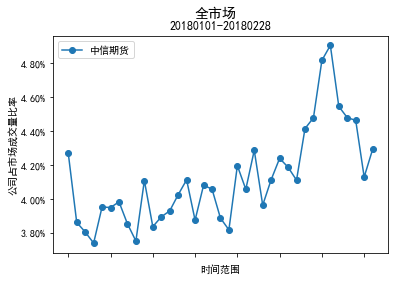

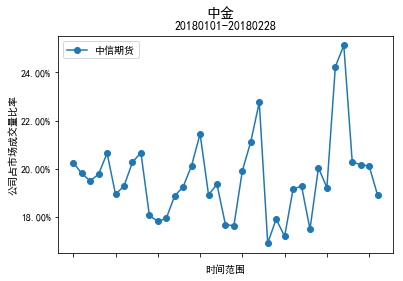

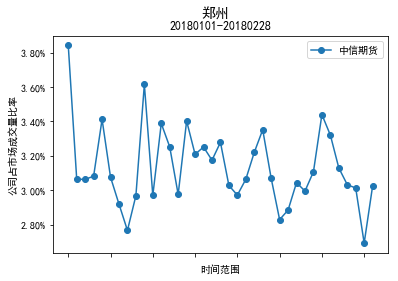

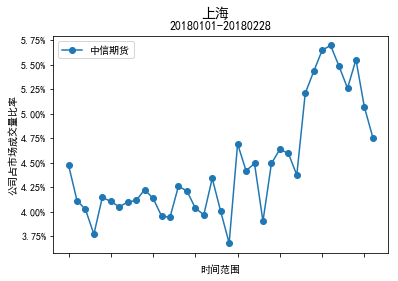

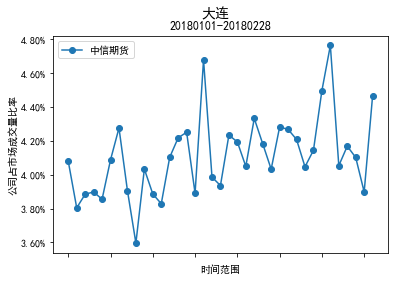

In [7]:
img_list = []
df_keys = ['全市场','中金', '郑州', '上海', '大连']
print(df_dict.keys())
# import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
filename = "期货持仓分析报告2"
pdf = PdfPages('{filename}.pdf'.format(filename=filename))
for key in df_keys:
    cp_df = df_dict[key].copy()
    cp_df = cp_df.reset_index()
    test_df = cp_df[['time', 'sum_market', 'sum_corpor', ]]
    name_map = {'time': '时间', 'sum_market': '市场成交量', 'sum_corpor': '中信成交量', }
    test_df = test_df.rename(name_map, axis='columns')
    print(test_df)
    
    test_df['中信期货'] = test_df['中信成交量'] / test_df['市场成交量']
    # test_df = test_df.reset_index()
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    

    fig, axes = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(6)
    # dates.dt.strftime('%Y-%m-%d')
    test_df['时间'] = test_df['时间'].apply(lambda x: x.strftime('%m-%d'))
    
    # test_df['时间'] = test_df['时间'].dt.strftime('%Y%m%d')
    # test_df = test_df.set_index(test_df['时间'])
    print(test_df)
    ax = test_df.plot(
        x='时间', y='中信期货',linestyle='-', marker='o',ax=axes,)

    def currency(x, pos):
        'The two args are the value and tick position'
        if x >= 1000000:
            return '${:1.1f}M'.format(x * 1e-6)
        return '${:1.0f}K'.format(x * 1e-3)

    def position(x, pos):
        'The two args are the value and tick position'
        if x >= 1000000:
            return '{:1.1f}M'.format(x * 1e-6)
        return '{:1.0f}K'.format(x * 1e-3)

    def percent(x, pos):
        return '%.2f%%' % (x * 100)
    
    def date_for(x, pos):
            
        return x

    formatter = FuncFormatter(percent)
    pos_formatter = FuncFormatter(position)
    date_fomatter = FuncFormatter(date_for)
    ax.yaxis.set_major_formatter(formatter)
    # axes.xaxis.set_major_formatter(date_fomatter)
    ax.set(title='20180101-20180228', xlabel='时间范围', ylabel='公司占市场成交量比率')
    # axes[1].xaxis.set_tick_params(rotation=45)
    fig.suptitle('{exchange}'.format(exchange=key), fontsize=14, fontweight='bold');
    imgdata = BytesIO()
    fig.savefig(imgdata, format="png")
    imgdata.seek(0)
    img_list.append(imgdata)
    pdf.savefig(fig)
    
pdf.close()
# workbook = xlsxwriter.Workbook('期货持仓分析报告.xlsx')
# worksheet = workbook.add_worksheet("全市场成交统计")
# num = 1
# for img in img_list:
#     # imgdata.seek(0)
#     # use with xlsxwriter
#     image_path = 'sales.png'
#     bound_width_height = (240, 240)
#     worksheet.insert_image('A{num}'.format(num=num), image_path, {'image_data': img, })
#     # image_path = '{exchange}期货交易所成交市场占比.png'.format(exchange=key)
#     # worksheet.insert_image('A{pos}'.format(pos=str(img_pos)), image_path, {'image_data': imgdata, })
#     num += 20
# 
# workbook.close()
# 
# filename = "期货持仓分析报告"



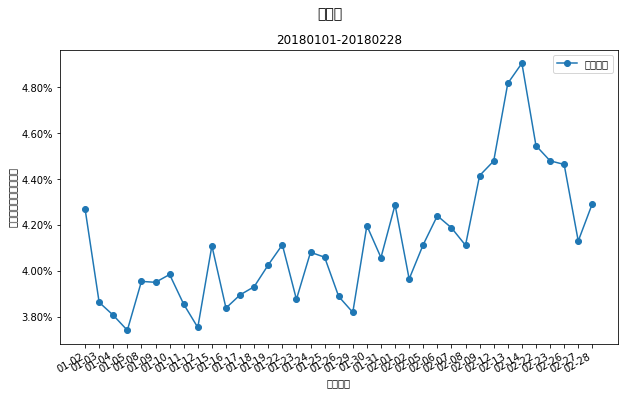

In [4]:
df_keys = ['全市场', '中金', '郑州', '上海', '大连']
fig, ax = plt.subplots(figsize=(10, 6))
key = '全市场'
cp_df = df_dict[key].copy()
cp_df = cp_df.reset_index()
test_df = cp_df[['time', 'sum_market', 'sum_corpor', ]]
name_map = {'time': '时间', 'sum_market': '市场成交量', 'sum_corpor': '中信成交量', }

test_df = test_df.rename(name_map, axis='columns')
test_df['时间'] = test_df['时间'].apply(lambda x: x.strftime('%m-%d'))
test_df['中信期货'] = test_df['中信成交量'] / test_df['市场成交量']
# print(test_df['时间'])
# test_df.plot(kind='bar', y="中信成交量", x="时间", ax=ax)
# test_df.plot( y="中信成交量", x="时间", ax=ax,)
# ax.set_xlim([-10000, 140000])
fig.suptitle('{exchange}'.format(exchange=key), fontsize=14, fontweight='bold');
ax.set(title='20180101-20180228', xlabel='时间范围', ylabel='公司占市场成交量比率')
def percent(x, pos):
    return '%.2f%%' % (x * 100)  # ax.legend().set_visible(False)
formatter = FuncFormatter(percent)
ax.legend(['中信占比',])
ax.yaxis.set_major_formatter(formatter)
l1 = plt.plot(test_df['时间'], test_df['中信期货'], linestyle='-', marker='o',label='中信期貨')
plt.legend(handles=l1)
# plt.xticks(rotation='vertical')
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.show()
# fig.legend((l1, ), ('Line 1',), "right")


dict_keys(['上海', '全市场', '郑州', '中金', '大连'])
           时间       市场成交量     中信成交量
0  2018-01-02  16984802.0  725225.0
1  2018-01-03  17067059.0  659143.0
2  2018-01-04  19994012.0  760929.0
3  2018-01-05  20261996.0  757809.0
4  2018-01-08  20317680.0  803234.0
5  2018-01-09  16462409.0  650164.0
6  2018-01-10  18755486.0  747125.0
7  2018-01-11  16559392.0  638174.0
8  2018-01-12  18366291.0  689174.0
9  2018-01-15  17714772.0  727874.0
10 2018-01-16  20130581.0  772415.0
11 2018-01-17  18558376.0  722764.0
12 2018-01-18  17002119.0  668215.0
13 2018-01-19  20733209.0  834565.0
14 2018-01-22  18058118.0  742742.0
15 2018-01-23  20582916.0  797618.0
16 2018-01-24  17845555.0  728180.0
17 2018-01-25  21173718.0  859439.0
18 2018-01-26  17660680.0  686563.0
19 2018-01-29  17095500.0  652751.0
20 2018-01-30  17563864.0  737057.0
21 2018-01-31  17987282.0  729794.0
22 2018-02-01  17394991.0  745789.0
23 2018-02-02  16917923.0  670601.0
24 2018-02-05  19049534.0  783705.0
25 2018-02-06  195899

           时间     市场成交量    中信成交量
0  2018-01-02   89762.0  18175.0
1  2018-01-03   80229.0  15883.0
2  2018-01-04   74620.0  14544.0
3  2018-01-05   60542.0  11967.0
4  2018-01-08   74336.0  15347.0
5  2018-01-09   65025.0  12310.0
6  2018-01-10   85536.0  16486.0
7  2018-01-11   89298.0  18094.0
8  2018-01-12   67591.0  13967.0
9  2018-01-15  100734.0  18188.0
10 2018-01-16   85689.0  15252.0
11 2018-01-17  121836.0  21847.0
12 2018-01-18  115359.0  21761.0
13 2018-01-19  109951.0  21162.0
14 2018-01-22   94374.0  18995.0
15 2018-01-23   87032.0  18662.0
16 2018-01-24   97029.0  18353.0
17 2018-01-25   88534.0  17124.0
18 2018-01-26   86812.0  15336.0
19 2018-01-29  104954.0  18499.0
20 2018-01-30   87482.0  17417.0
21 2018-01-31   95126.0  20092.0
22 2018-02-01  109117.0  24830.0
23 2018-02-02   97103.0  16409.0
24 2018-02-05  103226.0  18476.0
25 2018-02-06  138038.0  23712.0
26 2018-02-07  121869.0  23331.0
27 2018-02-08  125128.0  24115.0
28 2018-02-09  165127.0  28858.0
29 2018-02

           时间      市场成交量     中信成交量
0  2018-01-02  3387024.0  130115.0
1  2018-01-03  3381688.0  103629.0
2  2018-01-04  4718176.0  144542.0
3  2018-01-05  3790508.0  116830.0
4  2018-01-08  4018464.0  137122.0
5  2018-01-09  3327718.0  102365.0
6  2018-01-10  3557058.0  103860.0
7  2018-01-11  3233558.0   89479.0
8  2018-01-12  3470910.0  103047.0
9  2018-01-15  3529662.0  127597.0
10 2018-01-16  4587286.0  136237.0
11 2018-01-17  3601718.0  122031.0
12 2018-01-18  4099180.0  133329.0
13 2018-01-19  4849336.0  144310.0
14 2018-01-22  4359788.0  148351.0
15 2018-01-23  4546308.0  145896.0
16 2018-01-24  4711464.0  153192.0
17 2018-01-25  4209688.0  133652.0
18 2018-01-26  3849690.0  126213.0
19 2018-01-29  3763952.0  113979.0
20 2018-01-30  4176916.0  124134.0
21 2018-01-31  4328780.0  132634.0
22 2018-02-01  3561836.0  114698.0
23 2018-02-02  3465230.0  116152.0
24 2018-02-05  3853728.0  118305.0
25 2018-02-06  4059388.0  114869.0
26 2018-02-07  3862716.0  111446.0
27 2018-02-08  43560

           时间       市场成交量     中信成交量
0  2018-01-02   6501486.0  291152.0
1  2018-01-03   7112008.0  292624.0
2  2018-01-04   8113074.0  326502.0
3  2018-01-05   8386462.0  316237.0
4  2018-01-08   8683398.0  360057.0
5  2018-01-09   6958586.0  285685.0
6  2018-01-10   8561396.0  346690.0
7  2018-01-11   7056628.0  289260.0
8  2018-01-12   7510152.0  309023.0
9  2018-01-15   7326760.0  309554.0
10 2018-01-16   8061270.0  333510.0
11 2018-01-17   8478880.0  335555.0
12 2018-01-18   7154966.0  282040.0
13 2018-01-19   9108930.0  388012.0
14 2018-01-22   7542218.0  317756.0
15 2018-01-23   8571250.0  346062.0
16 2018-01-24   7498644.0  297543.0
17 2018-01-25  10171338.0  441469.0
18 2018-01-26   7195974.0  288084.0
19 2018-01-29   7161398.0  263510.0
20 2018-01-30   7570264.0  355273.0
21 2018-01-31   7547120.0  333482.0
22 2018-02-01   7309944.0  328413.0
23 2018-02-02   7340418.0  286475.0
24 2018-02-05   8323604.0  373977.0
25 2018-02-06   9275770.0  430112.0
26 2018-02-07   6643800.0  3

           时间      市场成交量     中信成交量
0  2018-01-02  7006530.0  285783.0
1  2018-01-03  6493134.0  247007.0
2  2018-01-04  7088142.0  275341.0
3  2018-01-05  8024484.0  312775.0
4  2018-01-08  7541482.0  290708.0
5  2018-01-09  6111080.0  249804.0
6  2018-01-10  6551496.0  280089.0
7  2018-01-11  6179908.0  241341.0
8  2018-01-12  7317638.0  263137.0
9  2018-01-15  6757616.0  272535.0
10 2018-01-16  7396336.0  287416.0
11 2018-01-17  6355942.0  243331.0
12 2018-01-18  5632614.0  231085.0
13 2018-01-19  6664992.0  281081.0
14 2018-01-22  6061738.0  257640.0
15 2018-01-23  7378326.0  286998.0
16 2018-01-24  5538418.0  259092.0
17 2018-01-25  6704158.0  267194.0
18 2018-01-26  6528204.0  256930.0
19 2018-01-29  6065196.0  256763.0
20 2018-01-30  5729202.0  240233.0
21 2018-01-31  6016256.0  243586.0
22 2018-02-01  6414094.0  277848.0
23 2018-02-02  6015172.0  251565.0
24 2018-02-05  6768976.0  272947.0
25 2018-02-06  6116760.0  261850.0
26 2018-02-07  6097316.0  260203.0
27 2018-02-08  56647

'300dpi: plain paper prints\n600dpi: professional paper prints. Most commercial office printers reach this in their output.\n1200dpi: professional poster/brochure grade quality.'

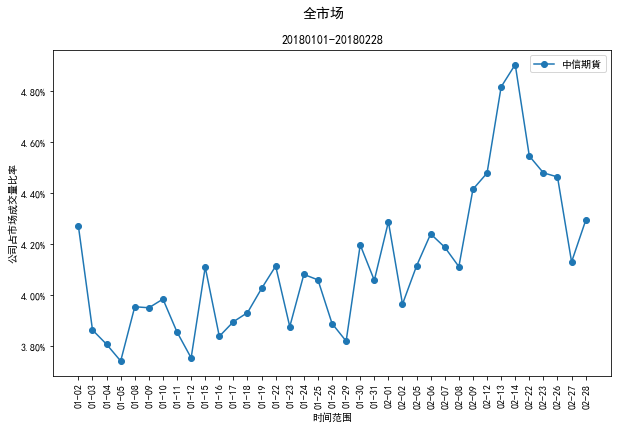

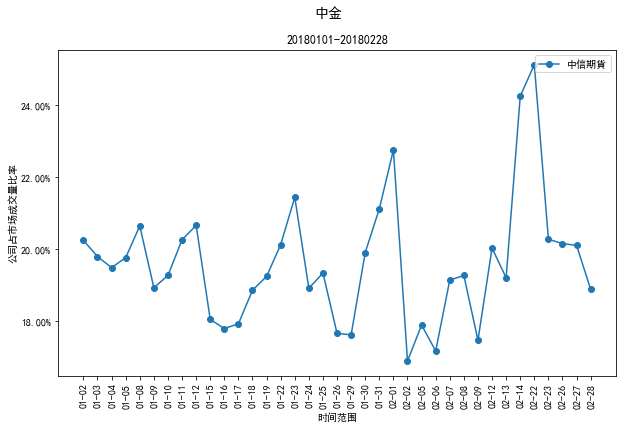

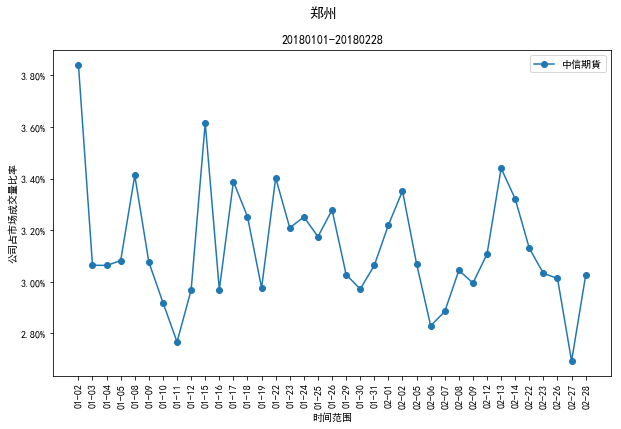

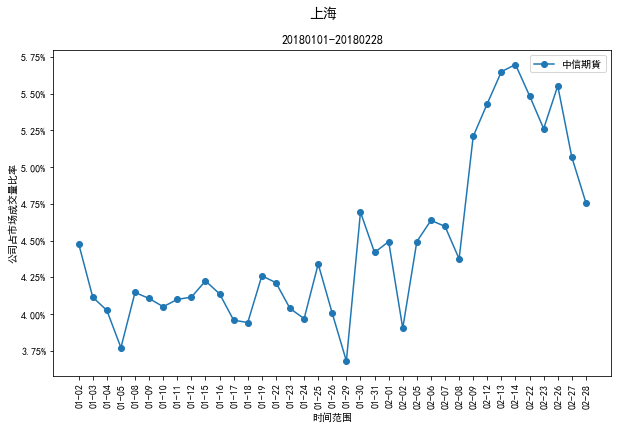

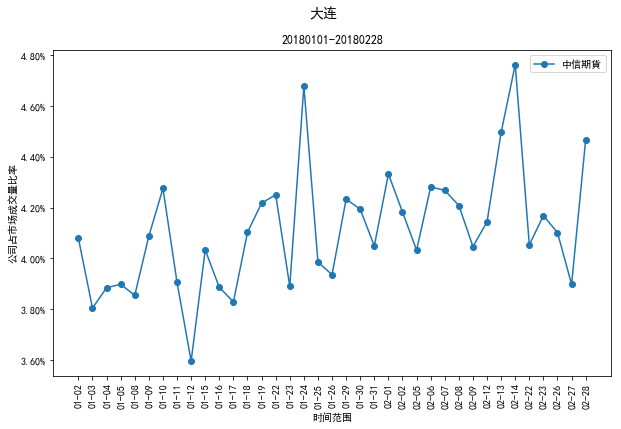

In [5]:
img_list = []
df_keys = ['全市场','中金', '郑州', '上海', '大连']
print(df_dict.keys())
# import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
filename = "期货持仓分析报告2"
pdf = PdfPages('{filename}.pdf'.format(filename=filename))
for key in df_keys:
    cp_df = df_dict[key].copy()
    cp_df = cp_df.reset_index()
    test_df = cp_df[['time', 'sum_market', 'sum_corpor', ]]
    name_map = {'time': '时间', 'sum_market': '市场成交量', 'sum_corpor': '中信成交量', }
    test_df = test_df.rename(name_map, axis='columns')
    print(test_df)
    
    test_df['中信期货'] = test_df['中信成交量'] / test_df['市场成交量']
    # test_df = test_df.reset_index()
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # dates.dt.strftime('%Y-%m-%d')
    test_df['时间'] = test_df['时间'].apply(lambda x: x.strftime('%m-%d'))
    
    # test_df['时间'] = test_df['时间'].ldt.strftime('%Y%m%d')
    # test_df = test_df.set_index(test_df['时间'])
    ax.yaxis.set_major_formatter(formatter)
    line = plt.plot(test_df['时间'], test_df['中信期货'], linestyle='-', marker='o', label='中信期貨')
    plt.legend(handles=line)
    plt.xticks(rotation='vertical')
    # plt.gcf().autofmt_xdate()
    # plt.show()
    def currency(x, pos):
        'The two args are the value and tick position'
        if x >= 1000000:
            return '${:1.1f}M'.format(x * 1e-6)
        return '${:1.0f}K'.format(x * 1e-3)

    def position(x, pos):
        'The two args are the value and tick position'
        if x >= 1000000:
            return '{:1.1f}M'.format(x * 1e-6)
        return '{:1.0f}K'.format(x * 1e-3)

    def percent(x, pos):
        return '%.2f%%' % (x * 100)
    
    def date_for(x, pos):
            
        return x

    formatter = FuncFormatter(percent)
    pos_formatter = FuncFormatter(position)
    date_fomatter = FuncFormatter(date_for)
    ax.yaxis.set_major_formatter(formatter)
    # axes.xaxis.set_major_formatter(date_fomatter)
    ax.set(title='20180101-20180228', xlabel='时间范围', ylabel='公司占市场成交量比率')
    # axes[1].xaxis.set_tick_params(rotation=45)
    
    fig.suptitle('{exchange}'.format(exchange=key), fontsize=14, fontweight='bold');
    imgdata = BytesIO()
    # fig.savefig('{name}.eps'.format(name=key), format='eps', dpi=1200)
    # fig.savefig('{name}.svg'.format(name=key), format='svg', dpi=1200)
    # fig.savefig('{name}.svg'.format(name=key), format='svg', dpi=1200)
    fig.savefig('{name}.png'.format(name=key), format='png', dpi=300)
    fig.savefig(imgdata, format="png", dpi=1200)
    imgdata.seek(0)
    img_list.append(imgdata)
    pdf.savefig(fig)
    
pdf.close()
# workbook = xlsxwriter.Workbook('期货持仓分析报告.xlsx')
# worksheet = workbook.add_worksheet("全市场成交统计")
# num = 1
# for img in img_list:
#     # imgdata.seek(0)
#     # use with xlsxwriter
#     image_path = 'sales.png'
#     bound_width_height = (240, 240)
#     worksheet.insert_image('A{num}'.format(num=num), image_path, {'image_data': img, })
#     # image_path = '{exchange}期货交易所成交市场占比.png'.format(exchange=key)
#     # worksheet.insert_image('A{pos}'.format(pos=str(img_pos)), image_path, {'image_data': imgdata, })
#     num += 20
# 
# workbook.close()
# 
# filename = "期货持仓分析报告"
# excel_to_pdf('{filename}.xlsx'.format(filename=filename), '{filename}.pdf'.format(filename=filename))
'''300dpi: plain paper prints
600dpi: professional paper prints. Most commercial office printers reach this in their output.
1200dpi: professional poster/brochure grade quality.'''

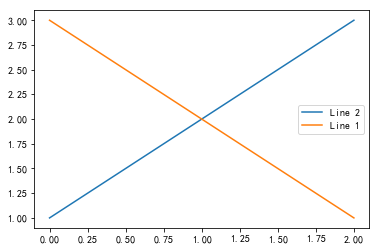

In [147]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# Do the plot code
line_up, = plt.plot([1,2,3], label='Line 2')
line_down, = plt.plot([3,2,1], label='Line 1')
plt.legend(handles=[line_up, line_down])
fig.savefig('myimage.svg', format='svg', dpi=1200)
